Zero-shot image classification is a task that involves classifying images into different categories using a model that was not explicitly trained on data containing labeled examples from those specific categories.

Traditionally, image classification requires training a model on a specific set of labeled images, and this model learns to “map” certain image features to labels. When there’s a need to use such model for a classification task that introduces a new set of labels, fine-tuning is required to “recalibrate” the model.

In contrast, zero-shot or open vocabulary image classification models are typically multi-modal models that have been trained on a large dataset of images and associated descriptions. These models learn aligned vision-language representations that can be used for many downstream tasks including zero-shot image classification.

This is a more flexible approach to image classification that allows models to generalize to new and unseen categories without the need for additional training data and enables users to query images with free-form text descriptions of their target objects .

In this guide you’ll learn how to:
1. create a zero-shot image classification pipeline
2. run zero-shot image classification inference by hand

# Libraries

In [1]:
pip install -q "transformers[torch]" pillow

Note: you may need to restart the kernel to use updated packages.


In [2]:
from transformers import pipeline, AutoProcessor, AutoModelForZeroShotImageClassification
from PIL import Image
import requests
import torch


2024-09-18 16:13:47.355277: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Zero-shot image classification pipeline

In [3]:
# Instantiate a pipeline from a checkpoint hosted on Hugging Face
checkpoint = "openai/clip-vit-large-patch14"
detector = pipeline(model=checkpoint, task="zero-shot-image-classification")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor confi

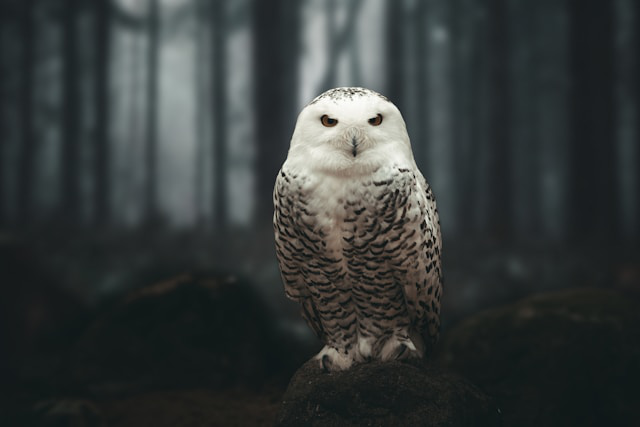

In [4]:
# Load an image for classification
url = "https://unsplash.com/photos/g8oS8-82DxI/download?ixid=MnwxMjA3fDB8MXx0b3BpY3x8SnBnNktpZGwtSGt8fHx8fDJ8fDE2NzgxMDYwODc&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

In [5]:
# Pass the image and the candidate object labels to the pipeline
# Here we pass the image directly; other suitable options include a local path to an image or an image url
# Also candidate labels can be simple words like in this example, or more descriptive
candidate_labels=["fox", "bear", "seagull", "owl", "other"]
predictions = detector(image, candidate_labels=candidate_labels)
predictions

[{'score': 0.9986214637756348, 'label': 'owl'},
 {'score': 0.0006801558774895966, 'label': 'other'},
 {'score': 0.0005536065436899662, 'label': 'seagull'},
 {'score': 8.240029274020344e-05, 'label': 'fox'},
 {'score': 6.24720414634794e-05, 'label': 'bear'}]

# Manual zero-shot image classification

In [6]:
# Load model from checkpoint, but this time don't instantiate a pipeline
model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


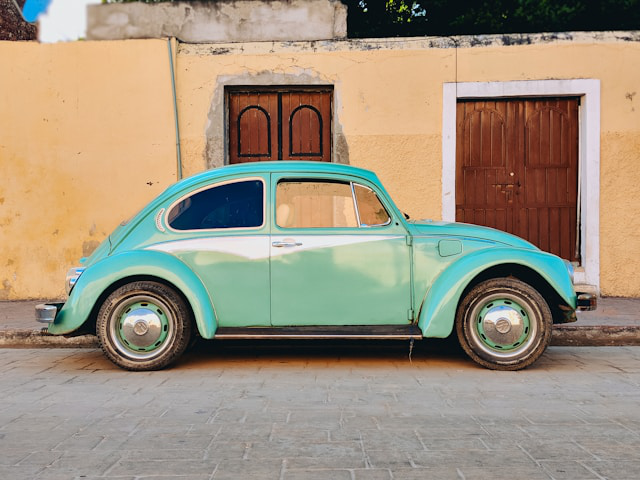

In [ ]:
# Load a different image to keep things fresh
url = "https://unsplash.com/photos/xBRQfR2bqNI/download?ixid=MnwxMjA3fDB8MXxhbGx8fHx8fHx8fHwxNjc4Mzg4ODEx&force=true&w=640"
image = Image.open(requests.get(url, stream=True).raw)

image

In [8]:
# Pass in candidate labels. Here a bit more text is automatically added to the labels instead of passing 1 word.
candidate_labels = ["tree", "car", "bike", "VW Beetle", 'cat']
candidate_labels = [f'This is a photo of {label}.' for label in candidate_labels]

# Use the processor to prepare the inputs for the model
# The processor = 
# (1) an image processor that prepares the image for the model by resizing and normalizing it
# + (2) a tokenizer that takes care of the text inputs
inputs = processor(images=image, text=candidate_labels, return_tensors="pt", padding=True)

In [9]:
# Pass the inputs through the model and score results
with torch.no_grad():
    outputs = model(**inputs)

logits = outputs.logits_per_image[0]
probs = logits.softmax(dim=-1).numpy()
scores = probs.tolist()

result = [
    {"score": score, "label": candidate_label}
    for score, candidate_label in sorted(zip(probs, candidate_labels), key=lambda x: -x[0])
]

result

[{'score': 0.8865114, 'label': 'This is a photo of VW Beetle.'},
 {'score': 0.11328012, 'label': 'This is a photo of car.'},
 {'score': 0.00017917929, 'label': 'This is a photo of bike.'},
 {'score': 1.9835086e-05, 'label': 'This is a photo of tree.'},
 {'score': 9.4047755e-06, 'label': 'This is a photo of cat.'}]